# <center> Funding Strategy Optimization & Startup Growth Prediction using RL model <center>

### Funding Strategy Optimization

Goal: Optimize the amount raised based on historical funding data.
State Space: Include startup characteristics like funding stage, amount raised, valuation, industry, etc.
Action Space: Possible actions could include different funding strategies (e.g., change funding vehicle, adjust amount raised).
Reward Function: Reward could be based on successful funding rounds or increased valuation.

### Startup Growth Prediction
Goal: Determine the best actions for startup growth.
State Space: Current valuation, funding stage, and amount raised.
Action Space: Actions like pivoting the business model or increasing funding.
Reward Function: Reward for successful growth indicators (e.g., revenue increase, further funding).

Here is the data:

| Column Name        | Description                                     |
|--------------------|-------------------------------------------------|
| Name               | Name of the startup                             |
| Date Funded        | Date of funding                                 |
| Funding Stage      | Stage of funding (e.g., Pre-SEED, Series A)      |
| Investment Vehicle | Type of investment (e.g., Equity, Debt)          |
| Amount Raised      | Amount raised in the round                       |
| Valuation          | Current valuation (if available)                 |
| Total Amount Raised| Cumulative funding received                      |
| Country            | Location of the startup                          |
| Primary Industry   | Industry category of the startup                 |
| Investors          | Names of investors involved                      |


* Please note that this a real data used from Magnitt website that has startup & funding information of EMENA region and I am using MENA region here for now

## 1.1 Initialization

In [3]:
!pip install gym

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam




In [4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/fatimaabdullah93/Desktop/MDX Masters - Data Science/CST4050 Modelling, regression and Machine Learning/Assignment 4/Magnitt-data-EMENA.xlsx"
%pip install openpyxl
df = pd.read_excel(file_path)



Note: you may need to restart the kernel to use updated packages.


In [5]:
df

,Name,Date Funded,Funding Stage,Investment Vehicle,Amount Raised,Valuation,Total Amount Raised,Country,Primary Industry,Investors
0,Maalexi,2024-07-01,Undisclosed,Venture Debt,$1M,-,$4M,United Arab Emirates (UAE),Transport & Logistics,Stride Ventures
1,جيل - Jeel,2024-06-01,Undisclosed,Equity,Undisclosed,-,Undisclosed,Saudi Arabia (KSA),EdTech,RZM investment
2,Comfi Payments,2024-06-01,Undisclosed,Conventional Debt,$5M,-,$5M,United Arab Emirates (UAE),FinTech,-
3,Tapper,2024-06-01,Pre-SEED,Equity,$250K,$4.5M - $5.5M,$250K,United Arab Emirates (UAE),Advertising and Marketing,AngelSpark
4,Konn Technologies Ltd,2024-06-01,Undisclosed,Equity,Undisclosed,-,$2M,Jordan,Construction & Infrastructure,Amam Ventures
...,...,...,...,...,...,...,...,...,...,...
393,erad,2023-09-01,Pre-SEED,Equity,$2.4M,$17.9M - $21.8M,$2.4M,Saudi Arabia (KSA),FinTech,Nuwa Capital
394,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,See All
395,Simma,2023-09-01,Undisclosed,Equity,Undisclosed,-,$1.5M,Jordan,FinTech,AHLI FINTECH
396,askPepper,2023-09-01,Undisclosed,Equity,Undisclosed,-,Undisclosed,Jordan,Food & Beverage,AHLI FINTECH


## Some data cleaning here

In [6]:

# Data preprocessing
df['Amount Raised'] = pd.to_numeric(df['Amount Raised'].replace({'\$': '', 'M': '000000', 'K': '000'}, regex=True), errors='coerce').fillna(0)
df['Valuation'] = df['Valuation'].str.split(' - ').str[0]
df['Valuation'] = pd.to_numeric(df['Valuation'].replace({'\$': '', 'M': '000000', 'K': '000'}, regex=True), errors='coerce').fillna(0)
df['Total Amount Raised'] = pd.to_numeric(df['Total Amount Raised'].replace({'\$': '', 'M': '000000', 'K': '000'}, regex=True), errors='coerce').fillna(0)


In [7]:
# Encoding categorical features
data = pd.get_dummies(df, columns=['Funding Stage', 'Investment Vehicle', 'Country', 'Primary Industry'])

# Display the preprocessed data
print(df.head())

                    Name Date Funded Funding Stage Investment Vehicle  \
0                Maalexi  2024-07-01   Undisclosed       Venture Debt   
1             جيل - Jeel  2024-06-01   Undisclosed             Equity   
2         Comfi Payments  2024-06-01   Undisclosed  Conventional Debt   
3                 Tapper  2024-06-01      Pre-SEED             Equity   
4  Konn Technologies Ltd  2024-06-01   Undisclosed             Equity   

   Amount Raised  Valuation  Total Amount Raised                     Country  \
0      1000000.0        0.0            4000000.0  United Arab Emirates (UAE)   
1            0.0        0.0                  0.0          Saudi Arabia (KSA)   
2      5000000.0        0.0            5000000.0  United Arab Emirates (UAE)   
3       250000.0        0.0             250000.0  United Arab Emirates (UAE)   
4            0.0        0.0            2000000.0                      Jordan   

                Primary Industry        Investors  
0          Transport & Logis

## Defining State and Action Spaces

In [8]:
# Extract relevant columns for state space
state_space = df[['Amount Raised', 'Valuation', 'Total Amount Raised']].values

# Define action space
action_space = ['Increase Funding', 'Decrease Funding', 'Change Funding Vehicle', 'Pivot Business Model']
action_dict = {action: i for i, action in enumerate(action_space)}


### Defining the Reward Function

In [9]:
# Initialize Q-table for Q-learning
num_states = state_space.shape[0]
num_actions = len(action_space)
q_table = np.zeros((num_states, num_actions))

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration factor

# Reward function
def reward_function(state, action):
    amount_raised = float(state[0])
    valuation = float(state[1])
    total_amount_raised = float(state[2])
    
    if action == action_dict['Increase Funding']:
        reward = (amount_raised * 0.1) + (valuation * 0.05)
    elif action == action_dict['Decrease Funding']:
        reward = (amount_raised * 0.05) - (valuation * 0.05)
    elif action == action_dict['Change Funding Vehicle']:
        reward = (total_amount_raised * 0.1)
    elif action == action_dict['Pivot Business Model']:
        reward = (valuation * 0.2)
    else:
        reward = 0
    
    return reward


### Building and Training the Model
Using Q-learning as an example to train the model.

In [10]:
# Example of training loop for Q-learning
def train_q_learning(epochs=1000):
    for epoch in range(epochs):
        state_index = np.random.choice(num_states)
        state = state_space[state_index]

        while True:
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(q_table[state_index])

            next_state_index = (state_index + 1) % num_states
            next_state = state_space[next_state_index]

            reward = reward_function(state, action)

            q_table[state_index, action] = q_table[state_index, action] + \
                alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])

            state_index = next_state_index
            state = next_state

            if state_index == 0:
                break

# Train the model
train_q_learning()

# Display the Q-table
print(q_table)

[[ 33184.68271817      0.              0.              0.        ]
 [ 94813.34940134      0.              0.              0.        ]
 [351190.41423019      0.              0.            589.5       ]
 ...
 [ 20119.08969184  18505.01293547  24191.78370154  16675.5171935 ]
 [ 26879.59300171  18946.6075334   18674.37170723  14645.69830539]
 [ 29866.21444635  19976.91031098  24610.63276734  20354.68324208]]


In [11]:
# Function to simulate actions from a given initial state
def simulate_actions(initial_state_index, num_steps=10):
    state_index = initial_state_index
    state = state_space[state_index]
    actions_taken = []
    rewards_received = []
    
    for step in range(num_steps):
        action = np.argmax(q_table[state_index])
        actions_taken.append(action_space[action])
        
        reward = reward_function(state, action)
        rewards_received.append(reward)
        
        state_index = (state_index + 1) % num_states
        state = state_space[state_index]
    
    return actions_taken, rewards_received

# Simulate actions from a random initial state
initial_state_index = np.random.choice(num_states)
actions_taken, rewards_received = simulate_actions(initial_state_index)

print("Actions Taken:", actions_taken)
print("Rewards Received:", rewards_received)

Actions Taken: ['Increase Funding', 'Increase Funding', 'Change Funding Vehicle', 'Increase Funding', 'Decrease Funding', 'Decrease Funding', 'Increase Funding', 'Change Funding Vehicle', 'Increase Funding', 'Decrease Funding']
Rewards Received: [100000.0, 0.0, 0.0, 900000.0, 0.17500000000000002, 0.0, 0.0, 0.0, 0.0, 0.0]


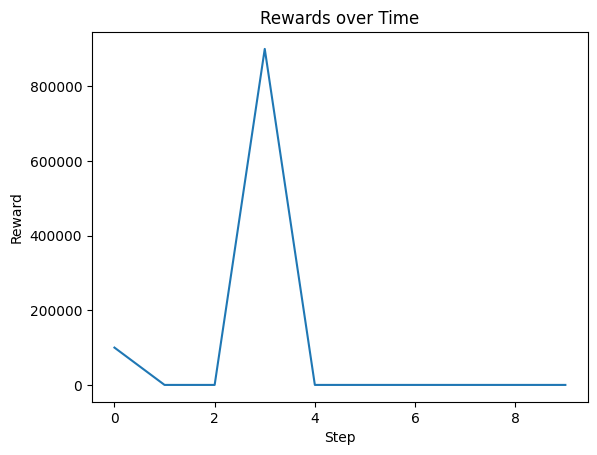

In [12]:
# Plot rewards over time
plt.plot(rewards_received)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Rewards over Time')
plt.show()

In [13]:
# Evaluate average reward per episode
def evaluate_model(episodes=100):
    total_rewards = 0
    
    for episode in range(episodes):
        state_index = np.random.choice(num_states)
        state = state_space[state_index]
        
        episode_reward = 0
        for step in range(10):
            action = np.argmax(q_table[state_index])
            reward = reward_function(state, action)
            episode_reward += reward
            
            state_index = (state_index + 1) % num_states
            state = state_space[state_index]
        
        total_rewards += episode_reward
    
    average_reward = total_rewards / episodes
    return average_reward

average_reward = evaluate_model()
print("Average Reward per Episode:", average_reward)

Average Reward per Episode: 8771638.770799998
